## Xray Lung Classifier 

---
### Project flow  

1) Importing the libraries and Loading the Images

2) Exploring the Images and transforming the Images

3) Creating the model Architecture

4) Training the Data

5) Evaluate the Model 

---
### Importing the libraries and Loading the Images

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

/home/jvdboss/workspace/ML_DL/image_classification/Lung_Xray_Classifier/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# changing the directory 
os.chdir('../artifacts/data_ingestion/chest_xray')

In [3]:
# Checking the current working directory 
!pwd

/home/jvdboss/workspace/ML_DL/image_classification/Lung_Xray_Classifier/artifacts/data_ingestion/chest_xray


In [4]:
# Data Path
data_path = '../chest_xray'

---
### Exploring the Images and transforming the Images

In [5]:
# Defining the class name 
class_name = ['NORMAL','PNEUMONIA']

# Creating a function to  get the list of files
def get_list_of_files(dir_name):
    '''
    input - The input directory location
    output - Returns the list the files in the directory
    '''
    files_list = os.listdir(dir_name)
    return files_list
files_list_normal_train = get_list_of_files(data_path+'/train/'+class_name[0])
files_list_pneumonia_train = get_list_of_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_of_files(data_path+'/test/'+class_name[0])
files_list_pneumonia_test = get_list_of_files(data_path+'/test/'+class_name[1])

In [6]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneumonia_train)))
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneumonia_test)))

Number of train samples in Normal category 100
Number of train samples in Pneumonia category 100
Number of test samples in Normal category 26
Number of test samples in Pneumonia category 26


---
### Exploring the images 

- Let's print the Normal and Pneumonia images from Training folder 

(560, 1000)


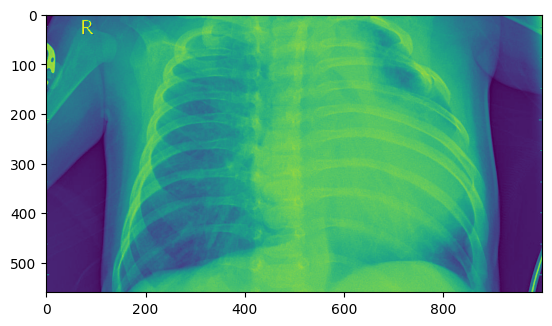

In [7]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(976, 1096)


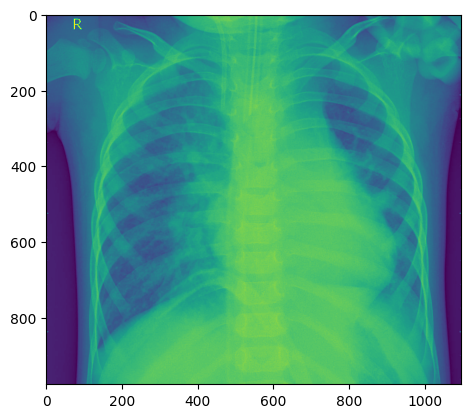

In [8]:
img = data_path + '/train/PNEUMONIA/'+ files_list_pneumonia_train[np.random.randint(0,len(files_list_pneumonia_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

### Insights 

- If we run the above cell mutiple times we can see that the images are of different shapes for the 'NORMAL' and 'PNEUMONIA' images in the **train** folder.

(624, 904)


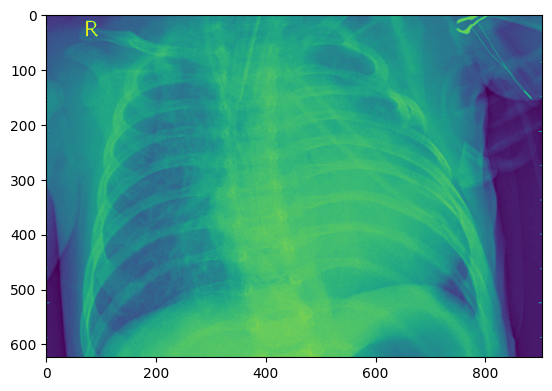

In [9]:
rand_img_no = np.random.randint(0,len(files_list_normal_test))
img = data_path + '/test/NORMAL/'+ files_list_normal_test[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(680, 1480)


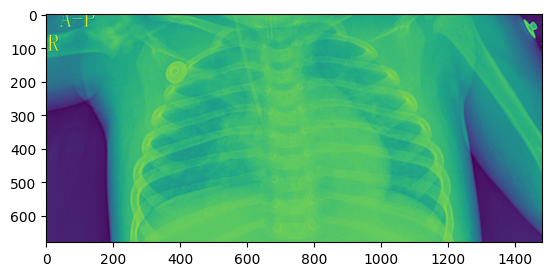

In [10]:
img = data_path + '/test/PNEUMONIA/'+ files_list_pneumonia_test[np.random.randint(0,len(files_list_pneumonia_test))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

### Insights 

- If we run the above cell mutiple times we can see that the images are of different shapes for the 'NORMAL' and 'PNEUMONIA' images in the **test** folder.

### Transforming the Images 

- Now that we have seen the sample of the images let's transform the data now 
- We need to perform transformation on both train and test images 
- For Training data we need to perform the data augmentation also.
- Data Augmentation is done to create synthetic data.

In **Transformation** we are doing Resize,CenterCrop,ColorJitter,RandomHorizontalFlip,RandomRotation,ToTensor and Normalize.

- Resize:- Resize the input image to the given size.
- CenterCrop:- Crops the given image at the center.
- ColorJitter:- Randomly change the brightness, contrast, saturation and hue of an image.
- RandomHorizontalFlip:- Horizontally flip the given image randomly with a given probability.
- RandomRotation:- Rotate the image by angle.
- ToTensor:- Convert numpy.ndarray to tensor.
- Normalize:- Normalize a float tensor image with mean and standard deviation.

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])


### Creating Data Loader

- For our usecase will be using the default data loader for Pytorch.
- We will be creating 2 data loaders one for the training data and other for the test data.
- batch size is a hyperparameter which we can tweak according to our need and system configuration.
- We can provide Image shuffling True for training data and False for test data.
- Pin memory is used to transfer the loaded dataset from CPU to GPU. 

In [12]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 2, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,
                         batch_size= 2, shuffle= False, pin_memory= True)
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 200
Number of test images: 52


---
### Creating the model Architecture

- First Layer is the **input layer** consisting of 3 input channels and output channels with kernel_size of 3X3, padding=0 and bias=True. The activation function we are using is ReLU and performing batch normalization.
- Then we are performing max pooling to extract the important features out of the image.
- Similarly we are passing our model through 9 convolutional layers.
- Finally we are passing out passing our model through a output layer in which we are getting binary classification.


In [14]:
class Net(nn.Module):
    def __init__(self):
        """
        Creating custom CNN architecture for Image classification
        """
        super(Net, self).__init__()
        # Input Block
        self.convolution_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pooling11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convolution_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=20, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling22 = nn.MaxPool2d(2, 2)
        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pooling33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(10),
#         )
        self.convolution_block6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(32)
#         )
        self.convolution_block7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convolution_block9 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convolution_block_out = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=True),
        )
    def forward(self, x):
        x = self.convolution_block1(x)
        x = self.pooling11(x)
        x = self.convolution_block2(x)
        x = self.pooling22(x)
        x = self.convolution_block3(x)
        x = self.pooling33(x)
        x = self.convolution_block4(x)
        x = self.convolution_block5(x)
#         x = self.convblock6(x)
        x = self.convolution_block6(x)
#         x = self.convblock8(x)
        x = self.convolution_block7(x)
        x = self.convolution_block8(x)
        x = self.convolution_block9(x)
        x = self.gap(x)
        x = self.convolution_block_out(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [15]:
# To check weather cuda is available in the system or not 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
# To check the model summary
summary(model, input_size=(3, 224, 224))

Available processor cpu
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       224
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-4                       1,460
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  40
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-7                       210
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  20
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-10                      1,820
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 40
├─Sequential: 1-8                        --
|    └─Conv2d: 2-13                    

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       224
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-4                       1,460
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  40
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-7                       210
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  20
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-10                      1,820
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 40
├─Sequential: 1-8                        --
|    └─Conv2d: 2-13                      672
|    └─ReLU: 2-14 

---
### Training the Data

In [16]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    """
    Description: To train the model 
    
    input: model,device,train_loader,optimizer,epoch 
    
    output: loss, batch id and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
def test(model, device, test_loader):
    """
    Description: To test the model
    
    input: model, device, test_loader
    
    output: average loss and accuracy
    
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
# Defining the params for training 
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 4
# Training the model
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6903982162475586 Batch_id=99 Accuracy=49.00: 100%|█| 100/100 [00:05<00:00


current Learning Rate:  0.01

Test set: Average loss: 1.2926, Accuracy: 26/52 (50.00%)

EPOCH: 1


Loss=0.6049677729606628 Batch_id=99 Accuracy=50.50: 100%|█| 100/100 [00:05<00:00


current Learning Rate:  0.01

Test set: Average loss: 0.8855, Accuracy: 26/52 (50.00%)

EPOCH: 2


Loss=1.3433219194412231 Batch_id=99 Accuracy=46.00: 100%|█| 100/100 [00:04<00:00


current Learning Rate:  0.01

Test set: Average loss: 0.9289, Accuracy: 26/52 (50.00%)

EPOCH: 3


Loss=0.6150071620941162 Batch_id=99 Accuracy=46.50: 100%|█| 100/100 [00:05<00:00


current Learning Rate:  0.01

Test set: Average loss: 0.7098, Accuracy: 26/52 (50.00%)



### Evaluate the Model 

- Plotting the graph for taining loss and training accuracy
- Plotting the graph for test loss and test accuracy 

Text(0.5, 1.0, 'Test Accuracy')

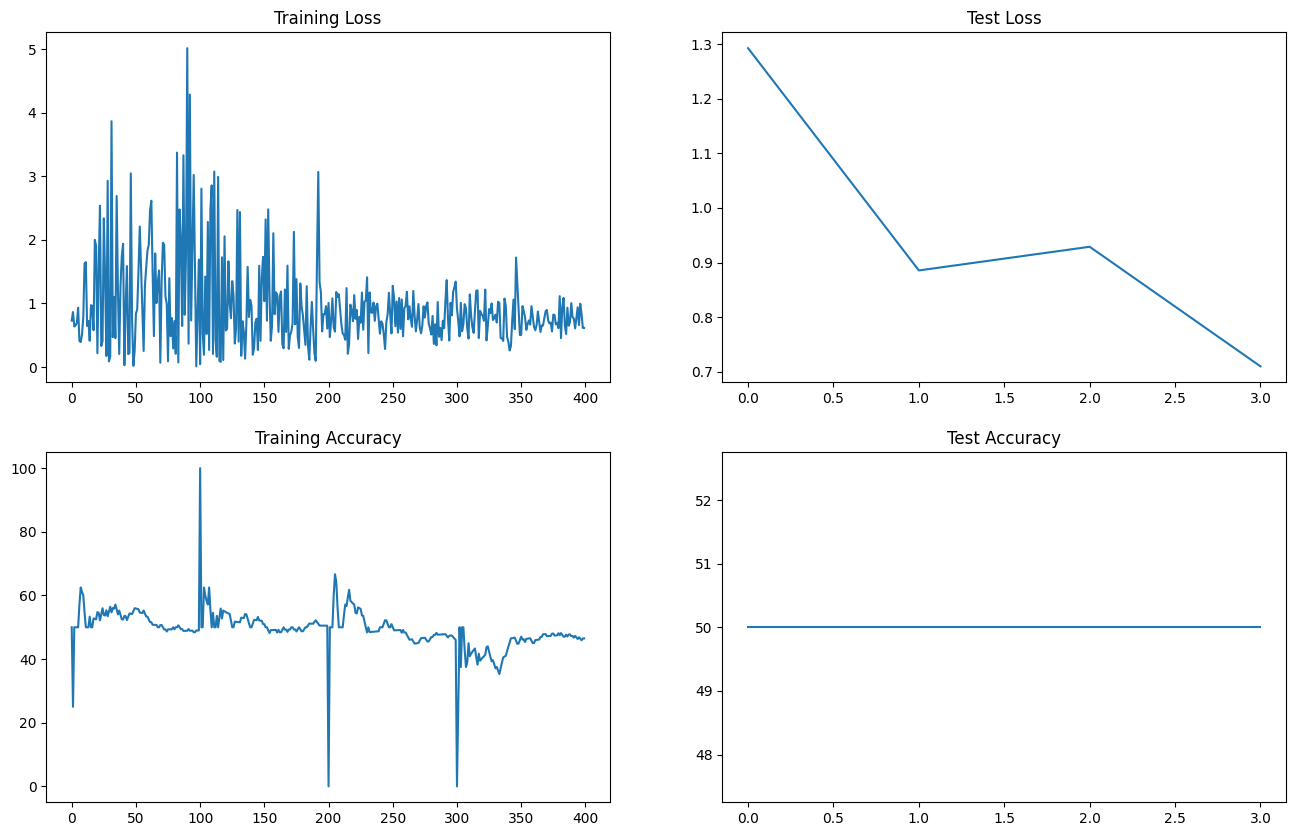

In [19]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")


### Insights

- As we can see from the above graph that training loss has many fluctuation at the start but then it consolidates over a period of time.
- From the training accuracy graph we are able to get a training accuracy of around 50% throughout
- Test loss graph decreases as the number of epochs increases.
- test accuracy remains constant at around 50%.